In [3]:
'''
author@diwakar
'''
import numpy as np
import pandas as pd
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
import datetime as dt

from subprocess import check_output
print(check_output(["ls", "/home/diwakar/Desktop/DCB"]).decode("utf8"))

code-2
loan-analysis.py
loan.csv
new-code
notebooks
prediction



In [4]:
nan_values = ['nan','N.A','NaN','n/a']
data = pd.read_csv('/home/diwakar/Desktop/DCB/loan.csv',na_values=nan_values, encoding = "ISO-8859-1", index_col='id')

/home/diwakar/Documents/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
pd.set_option('display.max_columns',100)
data.head(1)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.0,861.07,0.0,0.0,0.0,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data = data[data['funded_amnt']>0]
#2. columns such as issue_d, loan_states and last_pymnt_d are essential for calculating the loan period. remove rows with missing data
data = data[(data['issue_d'].notnull()) & (data['loan_status'].notnull())]
data = data[(data['last_pymnt_d'].notnull() | (data['loan_status']!='Fully Paid'))]
#3. convert a string date to datetime formate
def str_to_dt(a_string,conv_format='%b-%Y'):
    try:
        return dt.datetime.strptime(a_string,conv_format)
    except:
        return None    
data['issue_d'] = data['issue_d'].apply(str_to_dt)
data['last_pymnt_d'] = data['last_pymnt_d'].apply(str_to_dt)

In [6]:
compounded_nar_li = list()
simple_nar_li = list()

update_d = str_to_dt('Jan-2016') 
# calculate net annualized return for each loan (row-wise)
for index, row in data.iterrows():
    net_interest = row['total_rec_int'] + row['total_rec_late_fee'] - 0.01*row['total_pymnt_inv']
    net_charge_offs = 0

    # specify loan period based on the current loan status
    if row['loan_status'] == 'Fully Paid':
        loan_period = (row['last_pymnt_d'] - row['issue_d'])/ np.timedelta64(1,'D')/30
    elif row['loan_status'] == 'Charged Off':
        net_charge_offs = row['funded_amnt_inv'] - row['total_rec_prncp'] - row['recoveries'] + row['collection_recovery_fee']
        active_period = 0
        if row['last_pymnt_d']>dt.datetime(2006,12,30,0,0):
            active_period = (row['last_pymnt_d'] - row['issue_d'])/  np.timedelta64(1,'D')/30
        up_to_now = (update_d-row['issue_d'])/ np.timedelta64(1,'D')/30 -1
        #Charge off typically occurs when a loan is no later than 5 months past due
        loan_period = min(active_period+6, up_to_now)
    else:
        loan_period = (update_d-row['issue_d'])/ np.timedelta64(1,'D')/30 - 1
 
    loan_period = int(loan_period)  
    if loan_period>0:
        t=12/loan_period
    else:   #occasionally, the last repayment occured in the month of issuance
        t=12

    #calculate both compounded returns and simple returns
    compounded_nar = (1 + (net_interest-net_charge_offs) / row['funded_amnt'])**t -1 
    simple_nar = t*(net_interest-net_charge_offs)/row['funded_amnt']

    compounded_nar_li.append(compounded_nar)
    simple_nar_li.append(simple_nar)

In [7]:
data['simple_nar'] = simple_nar_li
data['compounded_nar'] =  compounded_nar_li
data = data[data['compounded_nar'].notnull()]

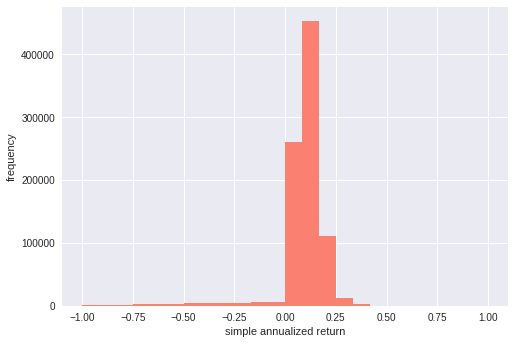

In [8]:
#plot histogram of annualized return
plt.hist(data['simple_nar'],color='salmon', bins=24, range=(-1,1), label='simple_nar')
plt.xlabel('simple annualized return')
plt.ylabel('frequency')

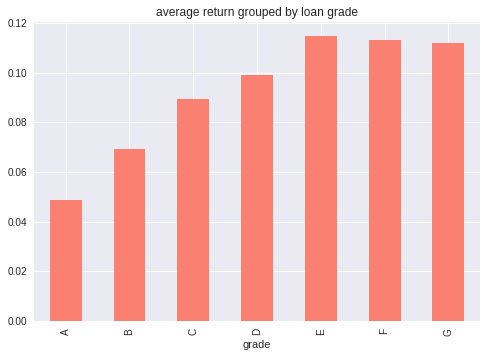

In [9]:
grade_group = data.groupby('grade')
grade_group.mean()['simple_nar'].plot(kind='bar', color='salmon')
plt.title('average return grouped by loan grade')

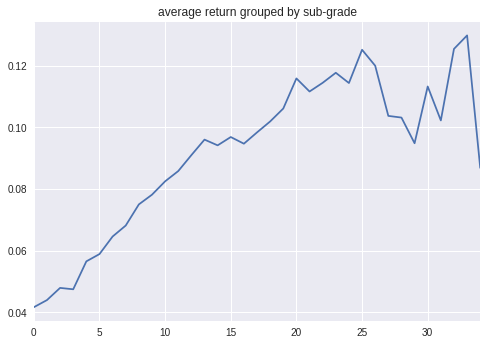

In [10]:
grade_group = data.groupby('sub_grade', as_index=False)
grade_group.mean()['simple_nar'].plot()
plt.title('average return grouped by sub-grade')

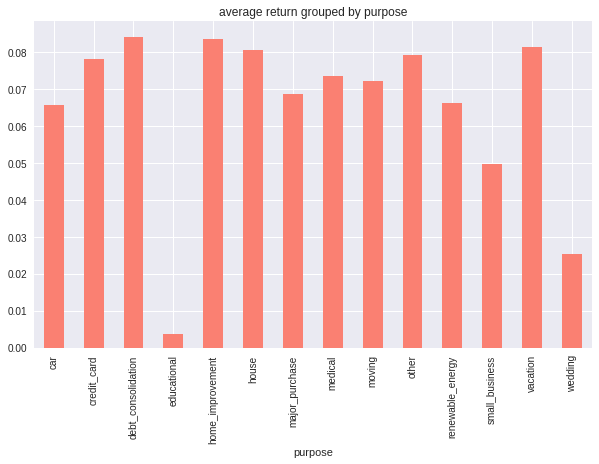

In [ ]:
purpose_group = data.groupby('purpose')
purpose_group.mean()['simple_nar'].plot(kind='bar',figsize=(10,6),color='salmon')
plt.title('average return grouped by purpose')

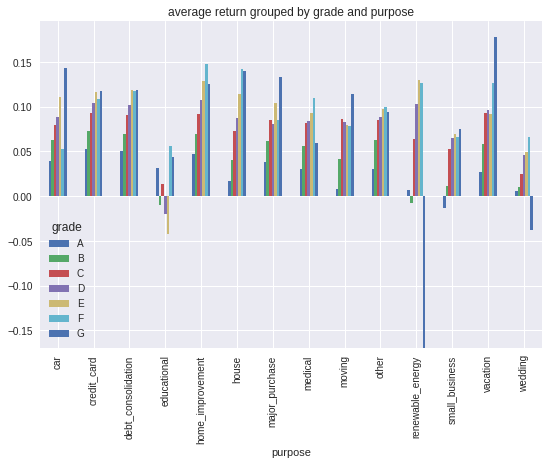

In [ ]:
gra_pur_group = data.groupby(['purpose','grade'])
gra_pur_group.mean()['simple_nar'].unstack().plot(kind='bar',figsize=(9,6))
plt.title('average return grouped by grade and purpose')

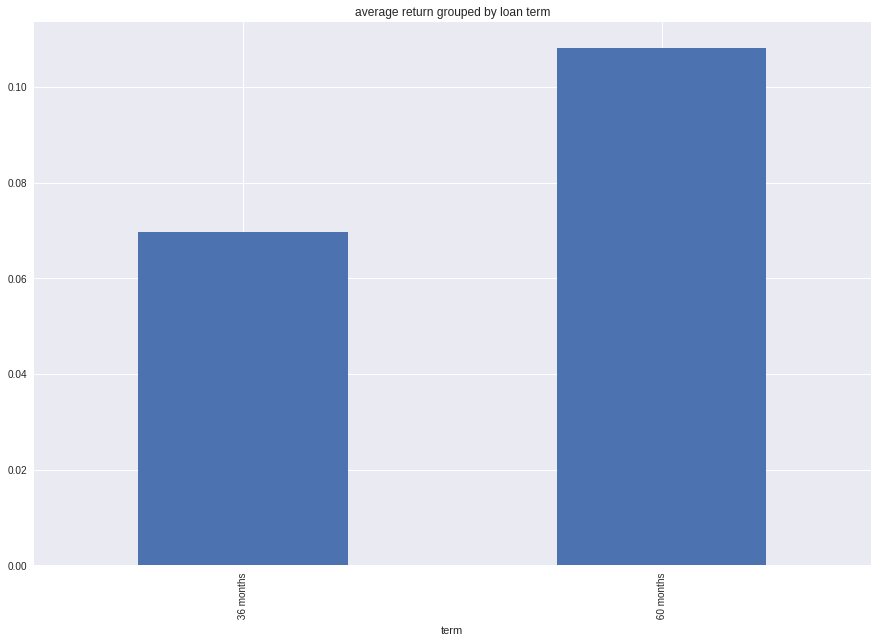

In [ ]:
term_group = data.groupby('term')
term_group.mean()['simple_nar'].plot(kind='bar',figsize=(15,10))
plt.title('average return grouped by loan term')